# 2D Integration in non-azimuthal space

In this tutorial, an image is intgrated in `qx/qy` space instead of `2theta/chi`. More fancy spaces are even possible ...

In [1]:
%matplotlib inline
# %matplotlib widget
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

In [2]:
import numpy
import pyFAI
from pyFAI.test.utilstest import UtilsTest
import fabio
from pyFAI.gui import jupyter
from pyFAI import units
from pyFAI.method_registry import Method,IntegrationMethod

<Axes: >

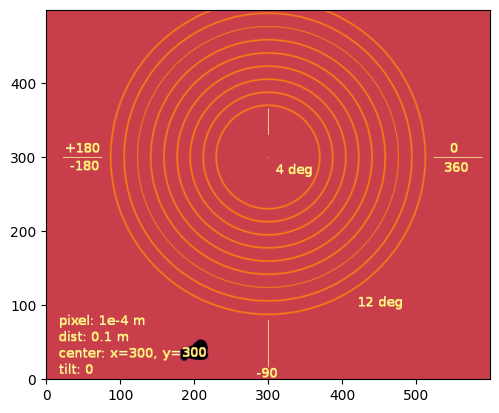

In [3]:
img = fabio.open(UtilsTest.getimage("moke.tif")).data
jupyter.display(img)

In [4]:
# According to the description in the image, we have:
det = pyFAI.detector_factory("Detector", {"pixel1":1e-4,"pixel2":1e-4})
ai = pyFAI.load({"detector": det, "wavelength": 1e-10})
ai.setFit2D(100, 300, 300)
ai

Detector Detector	 PixelSize= 100µm, 100µm	 BottomRight (3)
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m	PONI= 3.000000e-02, 3.000000e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=300.000, y=300.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å

In [5]:
len(IntegrationMethod.select_method(dim=2))

27

In [6]:
for m in IntegrationMethod.select_method(dim=2):
    print(m, end="")
    if m.algorithm=="histogram" and m.target is not None: 
        print("OpenCL histogram skipped")
        continue
    try:
        res = ai.integrate2d(img, 400,400, method=m, unit=("qx_nm^-1","qy_nm^-1"))
    except:
        print("broken")
    else:    
        print(f"{res[1].min():.2f}<qx<{res[1].max():.2f}, {res[2].min():.2f}<qy<{res[2].max():.2f} <I>={numpy.nanmean(res[0]):.2f} ± {numpy.nanstd(res[0]):.2f}")

IntegrationMethod(2d int, no split, histogram, python)-18.17<qx<18.17, -18.18<qy<12.31 <I>=10.60 ± 26.61
IntegrationMethod(2d int, no split, histogram, cython)-18.17<qx<18.17, -18.18<qy<12.31 <I>=10.60 ± 26.61
IntegrationMethod(2d int, bbox split, histogram, cython)-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38ython)
IntegrationMethod(2d int, pseudo split, histogram, cython)-18.20<qx<18.20, -18.21<qy<12.34 <I>=2.44 ± 13.72
IntegrationMethod(2d int, no split, CSR, cython)-18.17<qx<18.17, -18.18<qy<12.31 <I>=10.60 ± 26.61
-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(2d int, no split, CSR, python)-18.17<qx<18.17, -18.18<qy<12.31 <I>=10.60 ± 26.61
IntegrationMethod(2d int, bbox split, CSR, python)-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(2d int, no split, CSC, cython)-18.17<qx<18.17, -18.18<qy<12.31 <I>=10.60 ± 26.61
-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(

-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(2d int, no split, CSR, OpenCL, NVIDIA CUDA / NVIDIA L40S)-18.17<qx<18.17, -18.18<qy<12.31 <I>=10.60 ± 26.61
IntegrationMethod(2d int, full split, CSR, OpenCL, NVIDIA CUDA / NVIDIA L40S)-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(2d int, bbox split, LUT, OpenCL, NVIDIA CUDA / NVIDIA L40S)

-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38
IntegrationMethod(2d int, no split, LUT, OpenCL, NVIDIA CUDA / NVIDIA L40S)-18.17<qx<18.17, -18.18<qy<12.31 <I>=10.60 ± 26.61
IntegrationMethod(2d int, full split, LUT, OpenCL, NVIDIA CUDA / NVIDIA L40S)-18.20<qx<18.20, -18.21<qy<12.34 <I>=10.55 ± 24.38


IntegrationMethod(2d int, full split, CSR, cython)


<Axes: title={'center': '2D regrouping'}, xlabel='Rectilinear scattering vector $q_x$ ($nm^{-1}$)', ylabel='Rectilinear scattering vector $q_y$ ($nm^{-1}$)'>

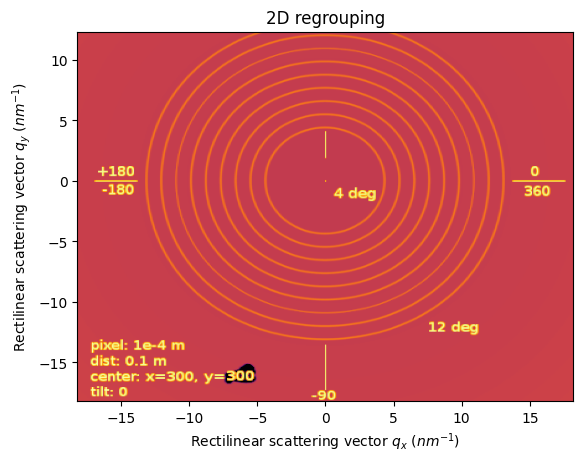

In [7]:
m = IntegrationMethod.select_method(dim=2, split="full", algo="CSR")[0]
print(m)
ai.reset()
res = ai.integrate2d(img, 400,400, method=m, unit=("qx_nm^-1", "qy_nm^-1"))
jupyter.plot2d(res)

In [8]:
ai._cached_array.keys()

dict_keys(['cos_incidence', 'solid_angle#3.0_crc', 'solid_angle#3.0', 'qx_corner', 'qy_corner'])

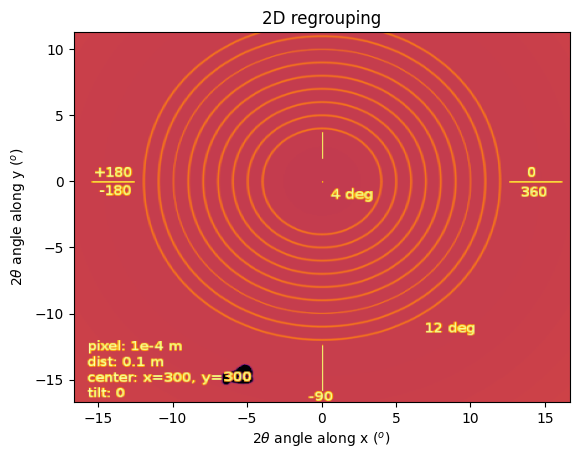

In [9]:
# Now with a new space: 2thx, 2thy:
tthx = pyFAI.units.register_radial_unit("tthx_deg",
                                        scale=180.0/numpy.pi,
                                        label=r"$2\theta$ angle along x ($^{o}$)",
                                        formula="arctan2(x,z)",
                                        short_name="2thx",
                                        unit_symbol="^{o}",
                                        positive=False)
tthy = pyFAI.units.register_azimuthal_unit("tthy_deg",
                                        scale=180.0/numpy.pi,
                                        label=r"$2\theta$ angle along y ($^{o}$)",
                                        formula="arctan2(y,z)",
                                        short_name="2thy",
                                        unit_symbol="^{o}",
                                        positive=False)
res = ai.integrate2d(img, 400,400, method=m, unit=("tthx_deg", "tthy_deg"))
jupyter.plot2d(res)
pass

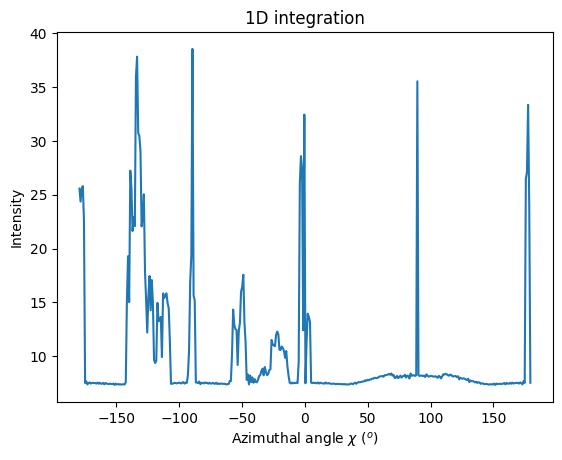

In [10]:
#Nota: it is also possible to integrate along the radial dim ... but for now, no way to provide limitation in radius.
jupyter.plot1d(ai.integrate1d(img, 400, unit="chi_deg", method=("no", "histogram", "cython")))
pass